In [ ]:
!pip install transformers datasets tweet-preprocessor ray[tune] hyperopt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import preprocessor as p # tweet-preprocessor
import nltk
import re
import seaborn as sns
import torch

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.special import softmax
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch

In [3]:
dataset_dem = pd.read_csv('/content/drive/MyDrive/democrat_tweets_v2.csv')
dataset_gop = pd.read_csv('/content/drive/MyDrive/republican_tweets_v2.csv')

dataset_dem["label"] = "Democrat"
dataset_gop["label"] = "Republican"

dataset_final = pd.concat([dataset_dem, dataset_gop])
dataset_final.reset_index(drop=True, inplace=True)

In [4]:
LABEL_MAP = {
    "Democrat": 0,
    "Republican": 1
}

def buildLabels(row):
    return LABEL_MAP.get(row["label"])

def cleanTweet(row):
  tweet = row["text"]
  tweet = str(p.clean(tweet))
  tweet = re.sub(r'[^\w\s]', '', tweet) # punctuation
  tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet) # numbers
  return tweet

  
dataset_final["label"] = dataset_final.apply(lambda row: buildLabels(row), axis=1)
dataset_final["clean_text"] = dataset_final.apply(lambda row: cleanTweet(row), 
                                                  axis=1)

In [5]:
dataset_clf = dataset_final[["clean_text", "label"]]
dataset_clf.reset_index(drop=True, inplace=True)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(dataset_clf.index.values, 
                                                  dataset_clf.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=dataset_clf.label.values)

dataset_clf['data_type'] = ['not_set']*dataset_final.shape[0]

dataset_clf.loc[X_train, 'data_type'] = 'train'
dataset_clf.loc[X_val, 'data_type'] = 'test'

dataset_train = dataset_clf.loc[dataset_clf.data_type == 'train']
dataset_test = dataset_clf.loc[dataset_clf.data_type == 'test']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [7]:
def get_dataloaders(data, batch_size):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                            do_lower_case=True)
  # tokenize train and test data so BERT can understand it
  encoded_data_train = tokenizer.batch_encode_plus(
      data[data.data_type=='train'].clean_text.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding=True,
      max_length=64, 
      return_tensors='pt'
  )

  encoded_data_test = tokenizer.batch_encode_plus(
      data[data.data_type=='test'].clean_text.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding=True, 
      max_length=64, 
      return_tensors='pt'
  )


  # destructure out the input_ids, attention masks, and labels from tokenizer & encoder output
  input_ids_train = encoded_data_train['input_ids']
  attention_masks_train = encoded_data_train['attention_mask']
  labels_train = torch.tensor(data[data.data_type=='train'].label.values)

  input_ids_test = encoded_data_test['input_ids']
  attention_masks_test = encoded_data_test['attention_mask']
  labels_test = torch.tensor(data[data.data_type=='test'].label.values)

  train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
  test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)

  train_dataloader = DataLoader(train_data, 
                                sampler=RandomSampler(train_data), 
                                batch_size=batch_size)

  test_dataloader = DataLoader(test_data,
                              sampler=SequentialSampler(test_data),
                              batch_size=batch_size)
  
  return train_dataloader, test_dataloader

In [8]:
def auc_score(preds, labels):
  soft_preds = softmax(preds, axis=1) # logit -> probability
  if np.shape(preds)[1] > 2: # check for multi-class
    return roc_auc_score(labels, soft_preds, multi_class='ovr')
  else:
    soft_preds = soft_preds[:,1]
    return roc_auc_score(labels, soft_preds)

def acc_score_by_class(preds, labels):
  label_dict_inverse = {v: k for k, v in LABEL_MAP.items()} 

  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [9]:
def evaluate(model, dataloader, device):
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []
  
  for batch in dataloader:
      
      # convert data to CUDA
      batch = tuple(b.to(device) for b in batch)
      
      inputs = {
          'input_ids':      batch[0],
          'attention_mask': batch[1],
          'labels':         batch[2],
      }

      with torch.no_grad():        
          outputs = model(**inputs) # get predictions
          
      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
  
  loss_val_avg = loss_val_total/len(dataloader) 
  
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
          
  return loss_val_avg, predictions, true_vals

In [10]:
def train_and_hyperparam_search(config,
                                model_init, # function to init a clean version of the net
                                data,       # data as Pandas array
                                cv          # rounds of cross-validation
                                ):
  losses = []
  aucs = []
  skf = StratifiedKFold(n_splits=cv, shuffle=True)
  for train_idx, test_idx in skf.split(data.clean_text, data.label):
    model = model_init()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Device: {device}")

    optimizer = AdamW(model.parameters(),
                    lr=config['lr'],
                    eps=1e-8) # keep this the same, just prevents exploding gradients
    
    data.loc[train_idx, 'data_type'] = 'train'
    data.loc[test_idx, 'data_type'] = 'test'
    
    train_dataloader, test_dataloader = get_dataloaders(data,
                                                        config['batch_size'])

    for epoch in range(1, config['epochs']+1):
      model.train() # enter training mode
      loss_train_total = 0

      for batch in train_dataloader:
          model.zero_grad()
          
          # get CUDA data
          batch = tuple(b.to(device) for b in batch)
          
          inputs = {
              'input_ids':      batch[0],
              'attention_mask': batch[1],
              'labels':         batch[2],
          }

          outputs = model(**inputs) # evaluate
          
          # for reference, we are using cross-entropy loss here,
          # as implemented in https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward() # do backprop

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
              
      
      loss_train_avg = loss_train_total/len(train_dataloader)    
      print(f"Training loss for epoch {epoch}: {loss_train_avg}")        
      
      val_loss, predictions, true_vals = evaluate(model, test_dataloader, device)
      auc = auc_score(predictions, true_vals)

      losses.append(val_loss)
      aucs.append(auc)

  tune.report(loss=np.mean(losses), auc=np.mean(aucs))

In [11]:
from functools import partial

def model_init():
   return BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                        num_labels=2,
                                                        output_attentions=False,
                                                        output_hidden_states=False)   

   
config = {
    "lr": tune.choice([5e-5, 3e-5, 1e-5, 2e-5]),
    "batch_size": tune.choice([8, 16, 32]),
    "epochs": tune.choice([2, 3, 4])
}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)

reporter = CLIReporter(metric_columns=["loss", "auc", "training_iteration"])
hyperopt_search = HyperOptSearch(metric="loss", mode="min")

result = tune.run(
    partial(train_and_hyperparam_search, model_init=model_init, data=dataset_clf, cv=3),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=8,
    scheduler=scheduler,
    search_alg=hyperopt_search,
    progress_reporter=reporter
)

2020-12-07 21:22:31,034	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-12-07 21:22:33,553	WARNING experiment.py:274 -- No name detected on trainable. Using DEFAULT.
2020-12-07 21:22:33,555	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.
2020-12-07 21:22:33,561	WARNING function_runner.py:540 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


== Status ==
Memory usage on this node: 1.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2020-12-07_21-22-33
Number of trials: 1/8 (1 RUNNING)
+------------------+----------+-------+--------------+----------+-------+
| Trial name       | status   | loc   |   batch_size |   epochs |    lr |
|------------------+----------+-------+--------------+----------+-------|
| DEFAULT_521005aa | RUNNING  |       |           16 |        4 | 2e-05 |
+------------------+----------+-------+--------------+----------+-------+




(pid=1120) 2020-12-07 21:22:34.936266: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1120) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1120) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1120) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1120) Device: cuda
(pid=1120) Training loss for epoch 1: 0.6344756947623359
(pid=1120) Training loss for epoch 2: 0.4850283290701683
(pid=1120) Training loss for epoch 3: 0.3312927346036892
(pid=1120) Training loss for epoch 4: 0.19011070387381496


(pid=1120) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1120) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1120) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1120) Some weights of BertForSequenceClassification were 

(pid=1120) Device: cuda
(pid=1120) Training loss for epoch 1: 0.647163972108051
(pid=1120) Training loss for epoch 2: 0.4911114549396014
(pid=1120) Training loss for epoch 3: 0.30765219777822495
(pid=1120) Training loss for epoch 4: 0.1624445544386452


(pid=1120) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1120) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1120) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1120) Some weights of BertForSequenceClassification were 

(pid=1120) Device: cuda
(pid=1120) Training loss for epoch 1: 0.6538276925231471
(pid=1120) Training loss for epoch 2: 0.5087285366925326
(pid=1120) Training loss for epoch 3: 0.30577800682548323
(pid=1120) Training loss for epoch 4: 0.19240122441334104
Result for DEFAULT_521005aa:
  auc: 0.7897988565061524
  date: 2020-12-07_21-28-32
  done: false
  experiment_id: 4b82b22abbe3444dbbc18ed05f0fc021
  experiment_tag: 1_batch_size=16,epochs=4,lr=2e-05
  hostname: 1a044ccbed2f
  iterations_since_restore: 1
  loss: 0.7237968415518602
  node_ip: 172.28.0.2
  pid: 1120
  time_since_restore: 356.3485610485077
  time_this_iter_s: 356.3485610485077
  time_total_s: 356.3485610485077
  timestamp: 1607376512
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 521005aa
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.7237968415518602
Resources requested: 2/2 CPUs, 

(pid=1119) 2020-12-07 21:28:34.193059: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1119) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1119) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1119) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1119) Device: cuda
(pid=1119) Training loss for epoch 1: 0.6449412330232486
(pid=1119) Training loss for epoch 2: 0.4639995000278107


(pid=1119) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1119) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1119) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1119) Some weights of BertForSequenceClassification were 

(pid=1119) Device: cuda
(pid=1119) Training loss for epoch 1: 0.6801172807963207
(pid=1119) Training loss for epoch 2: 0.5532662931716803


(pid=1119) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1119) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1119) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1119) Some weights of BertForSequenceClassification were 

(pid=1119) Device: cuda
(pid=1119) Training loss for epoch 1: 0.6702775304967706
(pid=1119) Training loss for epoch 2: 0.5173599388864305
Result for DEFAULT_5224c030:
  auc: 0.796480368866903
  date: 2020-12-07_21-31-42
  done: false
  experiment_id: 0277174ec3204e68b74e1b97935b53f1
  experiment_tag: 2_batch_size=16,epochs=2,lr=2e-05
  hostname: 1a044ccbed2f
  iterations_since_restore: 1
  loss: 0.568403833930691
  node_ip: 172.28.0.2
  pid: 1119
  time_since_restore: 186.9030032157898
  time_this_iter_s: 186.9030032157898
  time_total_s: 186.9030032157898
  timestamp: 1607376702
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5224c030
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6461003377412756
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT

(pid=1325) 2020-12-07 21:31:44.514261: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1325) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1325) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1325) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1325) Device: cuda
(pid=1325) Training loss for epoch 1: 0.6524164843559265
(pid=1325) Training loss for epoch 2: 0.5297986179590225


(pid=1325) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1325) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1325) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1325) Some weights of BertForSequenceClassification were 

(pid=1325) Device: cuda
(pid=1325) Training loss for epoch 1: 0.626326152086258
(pid=1325) Training loss for epoch 2: 0.4502087497711182


(pid=1325) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1325) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1325) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1325) Some weights of BertForSequenceClassification were 

(pid=1325) Device: cuda
(pid=1325) Training loss for epoch 1: 0.6162830018997192
(pid=1325) Training loss for epoch 2: 0.4076379317045212
Result for DEFAULT_2825ec9a:
  auc: 0.7999167693411314
  date: 2020-12-07_21-34-37
  done: false
  experiment_id: a5aa0311a3154fb7ad36938b93d58194
  experiment_tag: 3_batch_size=32,epochs=2,lr=5e-05
  hostname: 1a044ccbed2f
  iterations_since_restore: 1
  loss: 0.5963040275375048
  node_ip: 172.28.0.2
  pid: 1325
  time_since_restore: 171.49289512634277
  time_this_iter_s: 171.49289512634277
  time_total_s: 171.49289512634277
  timestamp: 1607376877
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2825ec9a
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5963040275375048
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DE

(pid=1389) 2020-12-07 21:34:39.404653: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1389) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1389) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1389) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1389) Device: cuda
(pid=1389) Training loss for epoch 1: 0.6567918190149346
(pid=1389) Training loss for epoch 2: 0.4708369989136253
(pid=1389) Training loss for epoch 3: 0.3382879101807684
(pid=1389) Training loss for epoch 4: 0.22345347392062345


(pid=1389) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1389) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1389) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1389) Some weights of BertForSequenceClassification were 

(pid=1389) Device: cuda
(pid=1389) Training loss for epoch 1: 0.6292807711946844
(pid=1389) Training loss for epoch 2: 0.46356695670295844
(pid=1389) Training loss for epoch 3: 0.27738183209522055
(pid=1389) Training loss for epoch 4: 0.1497899397462136


(pid=1389) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1389) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1389) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1389) Some weights of BertForSequenceClassification were 

(pid=1389) Device: cuda
(pid=1389) Training loss for epoch 1: 0.639292995436023
(pid=1389) Training loss for epoch 2: 0.4393983995824149
(pid=1389) Training loss for epoch 3: 0.2181181340487768
(pid=1389) Training loss for epoch 4: 0.10801092401982375


2020-12-07 21:41:24,744	WARNING worker.py:1091 -- The actor or task with ID ffffffffffffffffbd5c534001000000 is pending and cannot currently be scheduled. It requires {GPU: 1.000000}, {CPU: 2.000000} for execution and {GPU: 1.000000}, {CPU: 2.000000} for placement, but this node only has remaining {GPU: 1.000000}, {node:172.28.0.2: 1.000000}, {accelerator_type:T4: 1.000000}, {CPU: 2.000000}, {memory: 7.177734 GiB}, {object_store_memory: 2.441406 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


Result for DEFAULT_9947feae:
  auc: 0.7964746723269617
  date: 2020-12-07_21-41-24
  done: true
  experiment_id: 6f22707d4d57487981d754949e52ea6b
  experiment_tag: 4_batch_size=8,epochs=4,lr=3e-05
  hostname: 1a044ccbed2f
  iterations_since_restore: 1
  loss: 0.9422783949067962
  node_ip: 172.28.0.2
  pid: 1389
  time_since_restore: 403.7108232975006
  time_this_iter_s: 403.7108232975006
  time_total_s: 403.7108232975006
  timestamp: 1607377284
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9947feae
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6600504345446825
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2020-12-07_21-22-33
Number of trials: 5/8 (1 PENDING, 4 TERMINATED)
+------------------+------------+-------+--------------+----------+--

(pid=1487) 2020-12-07 21:41:26.547564: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1487) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1487) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1487) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1487) Device: cuda
(pid=1487) Training loss for epoch 1: 0.6254799326862952
(pid=1487) Training loss for epoch 2: 0.4529098105061837


(pid=1487) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1487) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1487) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1487) Some weights of BertForSequenceClassification were 

(pid=1487) Device: cuda
(pid=1487) Training loss for epoch 1: 0.642683137132965
(pid=1487) Training loss for epoch 2: 0.4575235460969535


(pid=1487) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1487) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1487) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1487) Some weights of BertForSequenceClassification were 

(pid=1487) Device: cuda
(pid=1487) Training loss for epoch 1: 0.6366332465350025
(pid=1487) Training loss for epoch 2: 0.46718696327974096
Result for DEFAULT_018b5aec:
  auc: 0.8050686351375309
  date: 2020-12-07_21-45-00
  done: false
  experiment_id: 723b45b90b624b37a68205ab4036eaf9
  experiment_tag: 5_batch_size=8,epochs=2,lr=2e-05
  hostname: 1a044ccbed2f
  iterations_since_restore: 1
  loss: 0.5747440671955898
  node_ip: 172.28.0.2
  pid: 1487
  time_since_restore: 212.38935685157776
  time_this_iter_s: 212.38935685157776
  time_total_s: 212.38935685157776
  timestamp: 1607377500
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 018b5aec
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5963040275375048
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DE

(pid=1565) 2020-12-07 21:45:02.276318: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1565) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1565) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1565) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1565) Device: cuda
(pid=1565) Training loss for epoch 1: 0.6305889517369897
(pid=1565) Training loss for epoch 2: 0.4355132859764677
(pid=1565) Training loss for epoch 3: 0.28478610796872716


(pid=1565) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1565) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1565) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1565) Some weights of BertForSequenceClassification were 

(pid=1565) Device: cuda
(pid=1565) Training loss for epoch 1: 0.6527667092253463
(pid=1565) Training loss for epoch 2: 0.5040295574475419
(pid=1565) Training loss for epoch 3: 0.34936021926643496


(pid=1565) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1565) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1565) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1565) Some weights of BertForSequenceClassification were 

(pid=1565) Device: cuda
(pid=1565) Training loss for epoch 1: 0.7127363072200255
(pid=1565) Training loss for epoch 2: 0.7042820664367291
(pid=1565) Training loss for epoch 3: 0.7051242014976463
Result for DEFAULT_f42ecb76:
  auc: 0.6939735650222766
  date: 2020-12-07_21-50-09
  done: true
  experiment_id: b9e2b815d8374a1ea2563c20f2f48d60
  experiment_tag: 6_batch_size=8,epochs=3,lr=5e-05
  hostname: 1a044ccbed2f
  iterations_since_restore: 1
  loss: 0.7918491258965877
  node_ip: 172.28.0.2
  pid: 1565
  time_since_restore: 306.2473108768463
  time_this_iter_s: 306.2473108768463
  time_total_s: 306.2473108768463
  timestamp: 1607377809
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f42ecb76
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6600504345446825
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 acce

(pid=1665) 2020-12-07 21:50:11.864239: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1665) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1665) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1665) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1665) Device: cuda
(pid=1665) Training loss for epoch 1: 0.6745161582725216
(pid=1665) Training loss for epoch 2: 0.58263214128186
(pid=1665) Training loss for epoch 3: 0.47433577703707147
(pid=1665) Training loss for epoch 4: 0.35387815730740324


(pid=1665) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1665) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1665) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1665) Some weights of BertForSequenceClassification were 

(pid=1665) Device: cuda
(pid=1665) Training loss for epoch 1: 0.6741337216261661
(pid=1665) Training loss for epoch 2: 0.5670615838031576
(pid=1665) Training loss for epoch 3: 0.4313579820322268
(pid=1665) Training loss for epoch 4: 0.27681715658517797


(pid=1665) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1665) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1665) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1665) Some weights of BertForSequenceClassification were 

(pid=1665) Device: cuda
(pid=1665) Training loss for epoch 1: 0.6640467463117657
(pid=1665) Training loss for epoch 2: 0.5514544359963349
(pid=1665) Training loss for epoch 3: 0.42982620648061387
(pid=1665) Training loss for epoch 4: 0.32079635124013883
Result for DEFAULT_74ceb41c:
  auc: 0.7684222258419061
  date: 2020-12-07_21-56-08
  done: false
  experiment_id: 6541a540e7594a918fc7448428f33228
  experiment_tag: 7_batch_size=16,epochs=4,lr=1e-05
  hostname: 1a044ccbed2f
  iterations_since_restore: 1
  loss: 0.6195048225546876
  node_ip: 172.28.0.2
  pid: 1665
  time_since_restore: 354.8464059829712
  time_this_iter_s: 354.8464059829712
  time_total_s: 354.8464059829712
  timestamp: 1607378168
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74ceb41c
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6195048225546876
Resources requested: 2/2 CPUs, 

(pid=1721) 2020-12-07 21:56:09.999956: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1721) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1721) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1721) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1721) Device: cuda
(pid=1721) Training loss for epoch 1: 0.6219169512541607
(pid=1721) Training loss for epoch 2: 0.43349605407377684
(pid=1721) Training loss for epoch 3: 0.24190773585378522


(pid=1721) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1721) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1721) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1721) Some weights of BertForSequenceClassification were 

(pid=1721) Device: cuda
(pid=1721) Training loss for epoch 1: 0.6424132425977727
(pid=1721) Training loss for epoch 2: 0.4624850241222767
(pid=1721) Training loss for epoch 3: 0.2629095058925826


(pid=1721) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1721) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1721) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1721) Some weights of BertForSequenceClassification were 

(pid=1721) Device: cuda
(pid=1721) Training loss for epoch 1: 0.6515685322910848
(pid=1721) Training loss for epoch 2: 0.4735053219277449
(pid=1721) Training loss for epoch 3: 0.2638683040635754


2020-12-07 22:00:43,753	INFO tune.py:439 -- Total run time: 2293.49 seconds (2290.13 seconds for the tuning loop).


Result for DEFAULT_2d5a4212:
  auc: 0.793940510936234
  date: 2020-12-07_22-00-43
  done: true
  experiment_id: bb3b5d43ad8a423c9d85d986b06ecea1
  experiment_tag: 8_batch_size=16,epochs=3,lr=3e-05
  hostname: 1a044ccbed2f
  iterations_since_restore: 1
  loss: 0.6683696124785476
  node_ip: 172.28.0.2
  pid: 1721
  time_since_restore: 272.3134183883667
  time_this_iter_s: 272.3134183883667
  time_total_s: 272.3134183883667
  timestamp: 1607378443
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2d5a4212
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6439372175166176
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2020-12-07_21-22-33
Number of trials: 8/8 (8 TERMINATED)
+------------------+------------+-------+--------------+----------+-------+-----

Text(0, 0.5, 'Score')

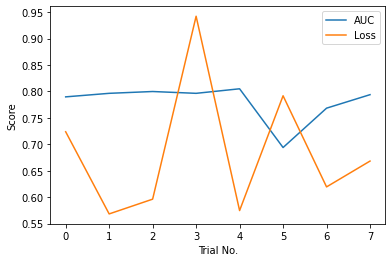

In [12]:
dfs = result.fetch_trial_dataframes()

aucs = []
losses = []
for d in dfs.values():
  aucs.append(d.auc)
  losses.append(d.loss)

plt.plot(range(0, 8), aucs, label="AUC")
plt.plot(range(0, 8), losses, label="Loss")
plt.legend()
plt.xlabel("Trial No.")
plt.ylabel("Score")


best candidates appear to come from trials 1 & 4.
let's evaluate both

In [13]:
def train(model, epochs, train_dataloader, test_dataloader, optimizer, scheduler):
  for epoch in tqdm(range(1, epochs+1)): # use tqdm for a progress bar
    model.train() # enter training mode
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch}', leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        
        # get CUDA data
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }

        outputs = model(**inputs) # evaluate
        
        # for reference, we are using cross-entropy loss here,
        # as implemented in https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() # do backprop

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
          
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dataloader)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model, test_dataloader, device)
    auc = auc_score(predictions, true_vals)
    tqdm.write(f'Testing loss: {val_loss}')
    tqdm.write(f'AUC: {auc}')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [17]:
def new_train_test_split(dataset_clf):
  X_train, X_val, y_train, y_val = train_test_split(dataset_clf.index.values, 
                                                    dataset_clf.label.values, 
                                                    test_size=0.15, 
                                                    random_state=42, 
                                                    stratify=dataset_clf.label.values)

  dataset_clf['data_type'] = ['not_set']*dataset_final.shape[0]

  dataset_clf.loc[X_train, 'data_type'] = 'train'
  dataset_clf.loc[X_val, 'data_type'] = 'test'

  # dataset_train = dataset_clf.loc[dataset_clf.data_type == 'train']
  # dataset_test = dataset_clf.loc[dataset_clf.data_type == 'test']

In [31]:
new_train_test_split(dataset_clf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [32]:
# trial 1
# |  batch_size |   epochs |          lr |
# |          16 |        2 |       2e-05 |

import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 2
BATCH_SIZE = 16
lr = 2e-5


train_dataloader, test_dataloader = get_dataloaders(dataset_clf, BATCH_SIZE)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                    num_labels=2,
                                                    output_attentions=False,
                                                    output_hidden_states=False)

optimizer = AdamW(model.parameters(),
                  lr=lr,
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, 
                                            num_training_steps=len(train_dataloader)*EPOCHS)
model.to(device)

train(model, EPOCHS, train_dataloader, test_dataloader, optimizer, scheduler)
test_loss, preds, labels = evaluate(model, test_dataloader, device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.6181272949491229
Testing loss: 0.5496365648248921
AUC: 0.8155716832187421



Epoch 2
Training loss: 0.47342666061151595
Testing loss: 0.5491808601047682
AUC: 0.8301502419149478



Accuracy: 0.752112676056338
AUC Score: 0.8301502419149478
Test loss: 0.5491808601047682


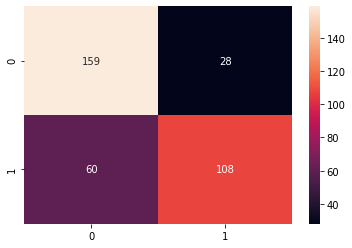

In [35]:
print(f"Accuracy: {accuracy_score(labels, np.argmax(preds, axis=1))}")
print(f"AUC Score: {auc_score(preds, labels)}")
print(f"Test loss: {test_loss}")
sns.heatmap(confusion_matrix(labels, np.argmax(preds, axis=1)), annot=True, fmt="d")

In [36]:
# trial 4
# |  batch_size |   epochs |          lr |
# |           8 |        2 |       2e-05 |

import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 2
BATCH_SIZE = 8
lr = 2e-5


train_dataloader, test_dataloader = get_dataloaders(dataset_clf, BATCH_SIZE)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                    num_labels=2,
                                                    output_attentions=False,
                                                    output_hidden_states=False)

optimizer = AdamW(model.parameters(),
                  lr=lr,
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, 
                                            num_training_steps=len(train_dataloader)*EPOCHS)
model.to(device)

train(model, EPOCHS, train_dataloader, test_dataloader, optimizer, scheduler)
test_loss, preds, labels = evaluate(model, test_dataloader, device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.6135795188565103
Testing loss: 0.5813115573591656
AUC: 0.7883562515915457



Epoch 2
Training loss: 0.4359586609616166
Testing loss: 0.5673864609665341
AUC: 0.8205373058314235



Accuracy: 0.7323943661971831
AUC Score: 0.8205373058314235
Test loss: 0.5673864609665341


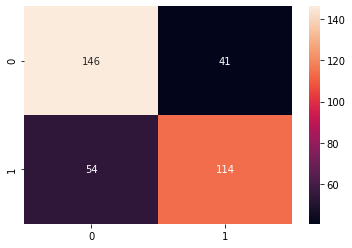

In [38]:
print(f"Accuracy: {accuracy_score(labels, np.argmax(preds, axis=1))}")
print(f"AUC Score: {auc_score(preds, labels)}")
print(f"Test loss: {test_loss}")
sns.heatmap(confusion_matrix(labels, np.argmax(preds, axis=1)), annot=True, fmt="d")

Trial # 1 seemed to go better (at least on the train-test split we evaluated both models on). Therefore, we will pick that trial as our winner and have the following hyperparameters:

- Batch Size: 16
- Epochs: 2
- Learning rate: 2e-5